# ML Powered Applications

# Chapter 4

Data preration notebook to better understand the data.

Objective
- To produce a data set that scores questions based on answers provided on writers.stackexcange.com

Process
- Import data
- Clean data types
- Flag outliers

In [1]:
# library dependencies
import pandas as pd
import numpy as np

# intialization
PATH_data = r"C:\Users\nrosh\Desktop\Personal Coding Projects\Python\ml-powered-applications\neel\data"

## Domain research

Data structure
1. PostType: 
    - {1: Question, 2: Answer}
2. AcceptedAnswerId: 
    - Row Id that answers a id. One Id can have many AcceptedAnswerId's
3. Score: 
    - Number of upvotes - Number of downvotes
4. ViewCount: 
    - Number of post views
5. body_text: 
    - Text associate with row entry id
6. FavoriteCount: 
    - Number of times the post was favorited
7. CommentCount: 
    - Number of times a comment was made on the Post
8. CreationDate: 
    - Date the post was created
9. LastActivityDate:
    - datetime of the post's most recent activity
10. LastEditDate
    - The date and time of the most recent edit to the post
11. ParentId
    - Row whose Parent is ParentId
Sources:
- stackexchange: 
    - Data Schema: https://meta.stackexchange.com/questions/2677/database-schema-documentation-for-the-public-data-dump-and-sede
    - Score: https://meta.stackexchange.com/questions/229255/what-is-the-score-of-a-post
    

## Functions

In [2]:
# Convert a value a datatype if not null
def convert_to(val, typefunc):
    if not np.isnan(val):
        return typefunc(val)
    else:
        return val

## Ingestion


In [3]:
# original
df_orig = pd.read_csv(
    PATH_data + "\\raw\Posts.csv", 
    index_col='Id'
)

# copies
df = df_orig.copy()

In [4]:
# observations
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42605 entries, 1 to 52454
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             42605 non-null  int64  
 1   AcceptedAnswerId       5081 non-null   float64
 2   AnswerCount            9935 non-null   float64
 3   Body                   42519 non-null  object 
 4   ClosedDate             1294 non-null   object 
 5   CommentCount           42605 non-null  int64  
 6   CommunityOwnedDate     192 non-null    object 
 7   ContentLicense         42605 non-null  object 
 8   CreationDate           42605 non-null  object 
 9   FavoriteCount          4052 non-null   float64
 10  LastActivityDate       42605 non-null  object 
 11  LastEditDate           15252 non-null  object 
 12  LastEditorDisplayName  988 non-null    object 
 13  LastEditorUserId       14439 non-null  float64
 14  OwnerDisplayName       3351 non-null   object 
 15  Ow

## Data Cleansing

In [5]:
# Define required columns
columns = [
    "PostTypeId", "AcceptedAnswerId", "ParentId", "AnswerCount", 
    "CommentCount", "FavoriteCount", "LastActivityDate", "CreationDate",
    "ClosedDate", "LastEditDate", "Score", "Title", "body_text" 
          ]

df1 = df.copy()
df1 = df1.loc[:, columns]
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42605 entries, 1 to 52454
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PostTypeId        42605 non-null  int64  
 1   AcceptedAnswerId  5081 non-null   float64
 2   ParentId          31935 non-null  float64
 3   AnswerCount       9935 non-null   float64
 4   CommentCount      42605 non-null  int64  
 5   FavoriteCount     4052 non-null   float64
 6   LastActivityDate  42605 non-null  object 
 7   CreationDate      42605 non-null  object 
 8   ClosedDate        1294 non-null   object 
 9   LastEditDate      15252 non-null  object 
 10  Score             42605 non-null  int64  
 11  Title             9935 non-null   object 
 12  body_text         42519 non-null  object 
dtypes: float64(4), int64(3), object(6)
memory usage: 4.6+ MB


In [6]:
# id type conversion
int_cols = ["AcceptedAnswerId", "ParentId"]
date_cols = ["LastActivityDate", "CreationDate", "ClosedDate", "LastEditDate"]

# convert to integer
for col in int_cols:
    df1.loc[:, col] = df1.loc[:, col].apply(lambda row: convert_to(row, int))

# convert to datetime
for col in date_cols:
    df1.loc[:, col] = pd.to_datetime(df1.loc[:, col])
    
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42605 entries, 1 to 52454
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   PostTypeId        42605 non-null  int64         
 1   AcceptedAnswerId  5081 non-null   float64       
 2   ParentId          31935 non-null  float64       
 3   AnswerCount       9935 non-null   float64       
 4   CommentCount      42605 non-null  int64         
 5   FavoriteCount     4052 non-null   float64       
 6   LastActivityDate  42605 non-null  datetime64[ns]
 7   CreationDate      42605 non-null  datetime64[ns]
 8   ClosedDate        1294 non-null   datetime64[ns]
 9   LastEditDate      15252 non-null  datetime64[ns]
 10  Score             42605 non-null  int64         
 11  Title             9935 non-null   object        
 12  body_text         42519 non-null  object        
dtypes: datetime64[ns](4), float64(4), int64(3), object(2)
memory usage: 4.6+ MB


## Feature Engineering

1. Closed question -> Where ClosedDate is NaT
2. question/answer -> Differentiate between a question, answer and everything else
3. Comment Count -> High, medium, low based on histogram
4. Score Count -> High, medium, low based on histogram

In [7]:
# function definitions

In [8]:
# make copy
df2 = df1.copy()

In [9]:
# set fe fields
df2["fe_tenure"]         = np.inf # time to close questions in hours
df2["fe_isclosed"]       = 0 # open vs closed question
df2["fe_isquestion"]     = 0 # question or answer
df2["fe_isanswer"]       = 0 # question or answer
df2["fe_isfavorited"]    = 0 # whether post was favorited or not
df2["fe_wasedited"]      = 0 # whether post was edited or not


df2.head()

,PostTypeId,AcceptedAnswerId,ParentId,AnswerCount,CommentCount,FavoriteCount,LastActivityDate,CreationDate,ClosedDate,LastEditDate,Score,Title,body_text,fe_tenure,fe_isclosed,fe_isquestion,fe_isanswer,fe_isfavorited,fe_wasedited
Id,,,,,,,,,,,,,,,,,,,
1,1,15.0,NaN,10.0,7,19.0,2019-03-31 20:10:59.657,2010-11-18 20:40:32.857,2019-09-09 15:44:30.727,2019-02-10 04:06:33.283,32,What are some online guides for starting writers?,I've always wanted to start writing (in a tota...,inf,0,0,0,0,0
2,1,16.0,NaN,7.0,0,5.0,2018-04-29 19:35:55.850,2010-11-18 20:42:31.513,NaT,2018-04-29 19:35:55.850,23,What is the difference between writing in the ...,What kind of story is better suited for each p...,inf,0,0,0,0,0
3,1,31.0,NaN,5.0,1,10.0,2018-05-04 11:04:09.610,2010-11-18 20:43:28.903,NaT,2018-05-04 11:04:09.610,35,How do I find an agent?,"I finished my novel, and everyone I've talked ...",inf,0,0,0,0,0
5,1,NaN,NaN,8.0,1,4.0,2019-05-23 20:32:12.107,2010-11-18 20:43:59.693,NaT,2019-04-10 07:29:49.297,33,Decide on a theme/overarching meaning before w...,I want my short story to have a specific point...,inf,0,0,0,0,0
7,1,85.0,NaN,10.0,1,6.0,2018-04-29 19:26:50.553,2010-11-18 20:45:44.067,NaT,2010-11-18 21:16:41.767,22,What is Literary Fiction?,"I keep hearing about literary fiction, and how...",inf,0,0,0,0,0


In [10]:
# feature engineer - question/answer
df2.loc[df2["PostTypeId"] == 1, "fe_isquestion"]      = df2.loc[df2["PostTypeId"] == 1, "fe_isquestion"].apply(lambda row: 1)
df2.loc[df2["PostTypeId"] == 2, "fe_isanswer"]        = df2.loc[df2["PostTypeId"] == 2, "fe_isanswer"].apply(lambda row: 1)
df2.loc[df2["FavoriteCount"] > 0, "fe_isfavorited"]   = df2.loc[df2["FavoriteCount"] > 0, "fe_isfavorited"].apply(lambda row: 1)
df2.loc[df2.LastEditDate.isna(), "fe_wasedited"]      = df2.loc[df2.LastEditDate.isna(), "fe_wasedited"].apply(lambda row: 1)

# feature engineer - tenure of post in hours
df2.loc[:, 'fe_tenure'] = (df2["ClosedDate"] - df2["CreationDate"]).apply(
    lambda row: np.inf \
        if pd.isnull(row) \
        else (row.days)*24   
)
df2.head()

# feature engineer - post is open/closed
df2.loc[:, "fe_isclosed"] = df2["fe_tenure"].apply(lambda row: 0 if row == np.inf else 1)

## Data Exploration

<AxesSubplot:>

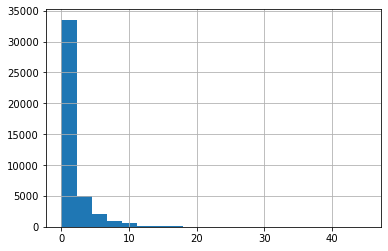

In [11]:
# Comments distributions
# High: 1 & 2
# Medium: 3 & 9
# Low: > 10

df2.loc[:, "CommentCount"].hist(bins=20)

<AxesSubplot:>

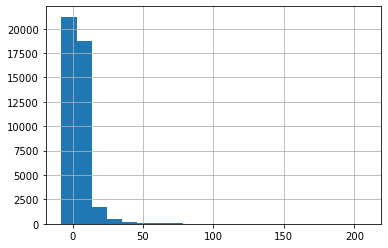

In [12]:
# Scores distributions
# Negative: < 0
# Average: 1 & 25
# High: > 26

df2.loc[:, "Score"].hist(bins=20)

count     1294.000000
mean      1976.698609
std       8755.975047
min          0.000000
25%          0.000000
50%         24.000000
75%         96.000000
max      77184.000000
Name: fe_tenure, dtype: float64


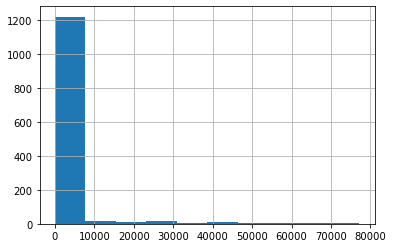

In [13]:
# tenure distribution of closed questions
df2.loc[df2["fe_isclosed"] == 1, "fe_tenure"].hist()
print(df2.loc[df2["fe_isclosed"]==1, "fe_tenure"].describe())

count    9935.000000
mean        3.214394
std         2.649237
min         0.000000
25%         1.000000
50%         2.000000
75%         4.000000
max        41.000000
Name: AnswerCount, dtype: float64


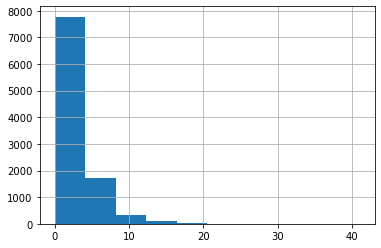

In [14]:
# Count of answers distribution of closed questions
df2.loc[:, "AnswerCount"].hist()
print(df2.loc[:, "AnswerCount"].describe())

count    4052.000000
mean        2.725814
std         5.171041
min         0.000000
25%         1.000000
50%         1.000000
75%         3.000000
max       227.000000
Name: FavoriteCount, dtype: float64


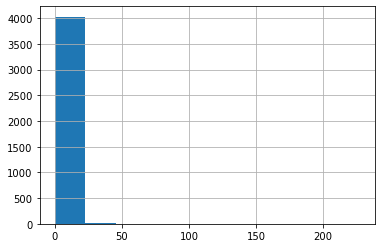

In [15]:
# Count of favorited distribution of closed questions
df2.loc[:, "FavoriteCount"].hist()
print(df2.loc[:, "FavoriteCount"].describe())

## Data Merging

- Produce the following dataframe;
1. questions_asked
2. answer_provided

SQL

    SELECT 
        df1.Title as Title,
        df1.body_text as question
        df2.body_text as accepted_answer
    FROM df2 as d1
    LEFT INNER JOIN df2 as d2
    ON df1.AcceptedAnswerId = df2.Id

In [16]:
df3 = df2.copy()
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42605 entries, 1 to 52454
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   PostTypeId        42605 non-null  int64         
 1   AcceptedAnswerId  5081 non-null   float64       
 2   ParentId          31935 non-null  float64       
 3   AnswerCount       9935 non-null   float64       
 4   CommentCount      42605 non-null  int64         
 5   FavoriteCount     4052 non-null   float64       
 6   LastActivityDate  42605 non-null  datetime64[ns]
 7   CreationDate      42605 non-null  datetime64[ns]
 8   ClosedDate        1294 non-null   datetime64[ns]
 9   LastEditDate      15252 non-null  datetime64[ns]
 10  Score             42605 non-null  int64         
 11  Title             9935 non-null   object        
 12  body_text         42519 non-null  object        
 13  fe_tenure         42605 non-null  float64       
 14  fe_isclosed       4260

In [17]:
# prepare dataframes
df_questions = df3.loc[df3["fe_isquestion"] == 1, :]
df_answers   = df3.loc[df3["fe_isanswer"] == 1, :]

# reset indexes
df_questions.reset_index(inplace=True)
df_answers.reset_index(inplace=True)

df_questions.to_csv(PATH_data+"\\out\post_questions.csv")
df_answers.to_csv(PATH_data+"\\out\post_answers.csv")
df3.to_csv(PATH_data+"\\out\cleaned_data.csv")

In [18]:
# left inner join questions and answers
df_qa = df_questions\
    .merge(df_answers, left_on="AcceptedAnswerId", right_on="Id", how="inner")

df_qa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5081 entries, 0 to 5080
Data columns (total 40 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Id_x                5081 non-null   int64         
 1   PostTypeId_x        5081 non-null   int64         
 2   AcceptedAnswerId_x  5081 non-null   float64       
 3   ParentId_x          0 non-null      float64       
 4   AnswerCount_x       5081 non-null   float64       
 5   CommentCount_x      5081 non-null   int64         
 6   FavoriteCount_x     2399 non-null   float64       
 7   LastActivityDate_x  5081 non-null   datetime64[ns]
 8   CreationDate_x      5081 non-null   datetime64[ns]
 9   ClosedDate_x        398 non-null    datetime64[ns]
 10  LastEditDate_x      3254 non-null   datetime64[ns]
 11  Score_x             5081 non-null   int64         
 12  Title_x             5081 non-null   object        
 13  body_text_x         5081 non-null   object      

In [19]:
# prepare dataframe and export
_df = df_qa.loc[:, 
                [
    "Title_x", "body_text_x", "body_text_y", 
    "CommentCount_x", "AnswerCount_x", "FavoriteCount_x", 
    "CommentCount_y", "Score_x", "fe_tenure_x", 
    "LastEditDate_x", "LastEditDate_y",
    "LastActivityDate_x", "LastActivityDate_y",
    "fe_isclosed_x", "fe_wasedited_x", "fe_wasedited_y"
#     "fe_isanswer_x"
                ]
]

_df\
    .rename(columns= {
        "Title_x"           : "post_title", 
        "body_text_x"       : "post_question", 
        "body_text_y"       : "post_acceptedanswer",
        "Score_x"           : "post_score",
        "CommentCount_x"    : "postcomments_count",
        "AnswerCount_x"     : "postanswers_count",
        "FavoriteCount_x"   : "postfavorites_count",
        "CommentCount_y"    : "answercomments_count",
        "fe_tenure_x"       : "tenure_hours",
        "fe_isclosed_x"     : "post_closed",
        "fe_wasedited_x"    : "question_edited", 
        "fe_wasedited_y"    : "answer_edited",
        "LastActivityDate_x": "question_lastactivity",
        "LastActivityDate_y": "answer_lastactivity",
        "LastEditDate_x"    : "question_lastedited",
        "LastEditDate_y"    : "answer_lastedited"
        }, inplace=True)
_df.to_csv(PATH_data+"\\out\questions_answers.csv")

## Sanity check's

In [20]:
# get questions received no answer
# how many received at least one
# how many had an answer that was accepted

df_hasnoanswer       = ((df3.fe_isquestion == 1) & (df3.AcceptedAnswerId.isna()) & (df3.AnswerCount < 1))
df_morethanoneanswer = ((df3.loc[df3.fe_isanswer == 1, "ParentId"].value_counts() > 1) == True)
df_acceptedAnswers   = df3.loc[(df3.fe_isquestion == 1) & (df3.AcceptedAnswerId.isna() == False)]

In [21]:
print(f"""

Questions that,

1. Recieved no answer: {df_hasnoanswer.value_counts().loc[True]}
2. Recieved more than one answer: {df_morethanoneanswer.value_counts().loc[True]} 
3. Recieved an answer that was accepted: {len(df_acceptedAnswers.index)}
""")



Questions that,

1. Recieved no answer: 257
2. Recieved more than one answer: 7234 
3. Recieved an answer that was accepted: 5081

